<a href="https://colab.research.google.com/github/shrisha-rao/zembo-demo/blob/main/Analysis_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
import os

########

# GCP project and bucket details
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/zembo-demo-2ebb06d8deb6.json"
########

# Load data

In [5]:
def load_data_from_bigquery_sql(project_id, dataset_id, table_id):
    """Loads specific columns from BigQuery using SQL into a Pandas DataFrame."""
    client = bigquery.Client(project=project_id)
    query = f"""
        SELECT
            t.Internal_temperature_of_battery,
            t.Surface_temperature_in_the_middle_of_cells,
            t.SOC,
            t.Total_voltage,
            t.BMS_PCB_board_surface_temperature,
            t.times_100_of_battery_capacity,
            t.Number_of_cycles,
            t.devId,
            t.timestamp as ts
        FROM
            `{project_id}.{dataset_id}.{table_id}` as t
        where t.devID like 'BGU%'
        and t.timestamp is not NULL
        and SOC >= 0 and SOC <= 100
        and Internal_temperature_of_battery >= 0
        and Surface_temperature_in_the_middle_of_cells >= 0
        and Total_voltage >= 0
        and BMS_PCB_board_surface_temperature >= 0
    """
    # 'Number_of_cycles', 'Internal_temperature_of_battery', 'SOC', 'Total_voltage'
    df = client.query(query).to_dataframe()
    return df


def load_data_from_bigquery_sql_query(query, project_id):
    """Loads specific columns from BigQuery using SQL into a Pandas DataFrame."""
    client = bigquery.Client(project=project_id)
    df = client.query(query).to_dataframe()
    return df


def load_data_file(file_path, delimiter=','):
    """Loads data from a CSV file into a Pandas DataFrame."""
    try:
        df = pd.read_csv(file_path, delimiter=delimiter)
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None

def load_data(file_paths):
    # List to store DataFrames
    dfs = []
    combined_df = pd.DataFrame()

    # Iterate and read CSV files
    for file_path in file_paths:
        try:
            df = pd.read_csv(file_path)
            dfs.append(df)
        except FileNotFoundError:
            print(f"Error: File not found: {file_path}")

    # Concatenate DataFrames
    if dfs:
        combined_df = pd.concat(dfs, ignore_index=True)
        # Now you have a single DataFrame containing data from all files
        # print(combined_df)
    else:
        print("No valid files were found")

    return combined_df


# Data Preprocessing

In [3]:
def preprocess_data(df):
    """Preprocesses the DataFrame: converts time columns, handles missing values, etc."""
    if df is None:
        return None

    # Convert time columns to datetime objects if they exist.
    time_cols = ['ts', 'alarmTime', 'old_alarmTime', 'swap_in_date', 'swap_out_date']
    for col in time_cols:
        if col in df.columns:
            df[col] = pd.to_datetime(df[col], errors='coerce')

    # Coerce other columns to their inferred datatypes, replacing errors with NaN
    for col in df.columns:
        if col not in time_cols:  # Skip time columns (already handled)
            try:
                df[col] = pd.to_numeric(df[col], errors='coerce') #Try to convert to numeric
            except:
                try:
                    df[col] = df[col].astype("category") #try to convert to category
                except:
                    pass #if all fails, leave the column as it is.

    return df

# Analysis

In [4]:
def analyze_cycle_life(df):
    """Analyzes battery cycle life and identifies influencing factors."""
    if df is None:
        return

    # Basic visualizations (you can expand on these)
    plt.figure(figsize=(6, 4))
    #sns.histplot(df['Number_of_cycles'], bins=30, kde=True)
    sns.distplot(df['Number_of_cycles'], bins=30, kde=True) #modified line
    plt.title('Distribution of Battery Cycle Counts')
    plt.xlabel('Number of Cycles')
    plt.ylabel('Frequency')
    plt.show()

    # Surface_temperature_in_the_middle_of_cells
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x='Surface_temperature_in_the_middle_of_cells', y='Number_of_cycles', data=df)
    plt.title('Surface_temperature_in_the_middle_of_cells vs. Cycle Count')
    plt.xlabel('Surface Temperature (°C)')
    plt.ylabel('Number of Cycles')
    plt.show()

    # BMS_PCB_board_surface_temperature
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x='BMS_PCB_board_surface_temperature', y='Number_of_cycles', data=df)
    plt.title('PCB Temperature vs. Cycle Count')
    plt.xlabel('PCB Temperature (°C)')
    plt.ylabel('Number of Cycles')
    plt.show()

    # Temperature vs. Cycle Count
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x='Internal_temperature_of_battery', y='Number_of_cycles', data=df)
    plt.title('Internal Temperature vs. Cycle Count')
    plt.xlabel('Internal Temperature (°C)')
    plt.ylabel('Number of Cycles')
    plt.show()

    # SOC vs. Cycle Count
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x='SOC', y='Number_of_cycles', data=df)
    plt.title('SOC vs. Cycle Count')
    plt.xlabel('State of Charge (SOC)')
    plt.ylabel('Number of Cycles')
    plt.show()

    # Example: Correlation matrix
    # correlation_matrix = df[['Number_of_cycles', 'Internal_temperature_of_battery', 'SOC', 'Total_voltage']].corr()
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
    # plt.title('Correlation Matrix')
    # plt.show()

def analyze_swap_data(swap_df):
    """Analyzes battery swap data."""
    if swap_df is None:
        return

    # # Merge swap data
    # merged_swap = pd.merge(swap_in_df, swap_out_df, on='battery_id', suffixes=('_in', '_out'))

    # print('merged shape: ', merged_swap.shape)

    # # Calculate SOC difference
    # merged_swap['soc_difference'] = merged_swap['swap_out_SOC'] - merged_swap['swap_in_SOC']

    # Visualize SOC difference
    plt.figure(figsize=(6, 4))
    sns.histplot(swap_df['soc_difference'], bins=30, kde=True)
    #sns.distplot(merged_swap['soc_difference'], bins=30, kde=True) #modified line
    plt.title('Distribution of SOC Difference (Swap Out - Swap In)')
    plt.xlabel('SOC Difference')
    plt.ylabel('Frequency')
    plt.show()
    #print(merged_swap.head())


def get_swap_data(project_id, dataset_id):
  client = bigquery.Client(project=project_id)
  query = f"""
          SELECT soc_difference
          FROM `{project_id}.{dataset_id}.merged_swap_data`
          where swap_out_SOC >= 0 and swap_out_SOC <= 100
          and swap_in_SOC >= 0 and swap_in_SOC <= 100
          and soc_difference is not NULL
          """
  df = client.query(query).to_dataframe()
  return df

In [ ]:
project_id = "zembo-demo" # GCP project ID
dataset_id = 'zembo_data'  # BigQuery dataset ID
table_id = 'battery-data'  # BigQuery table ID

In [5]:
def main():
    """Main function to orchestrate data analysis."""

    #swap_df = preprocess_data(swap_df)




    #print(swap_in_df.shape, swap_out_df.shape)

    #
    # analyze_battery_maintenance(df)
    plt.show()

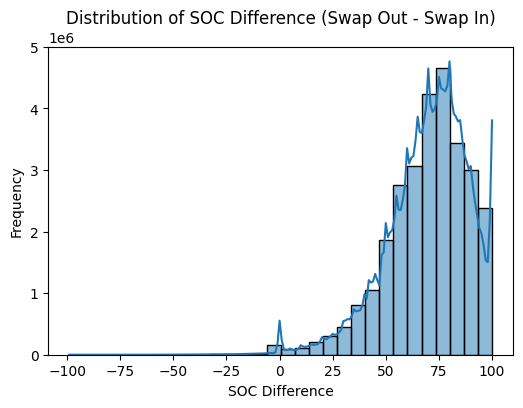

In [6]:
swap_df = get_swap_data(project_id, dataset_id)
print('swap shape:', swap_df.shape)
analyze_swap_data(swap_df)

(5071572, 9)


<ipython-input-7-1bdd8dd7bb1b>:111: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Number_of_cycles'], bins=30, kde=True) #modified line


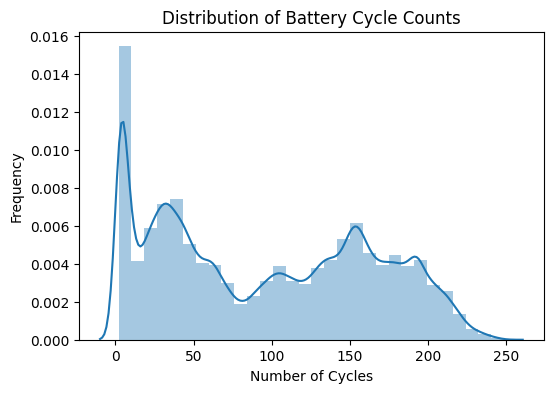

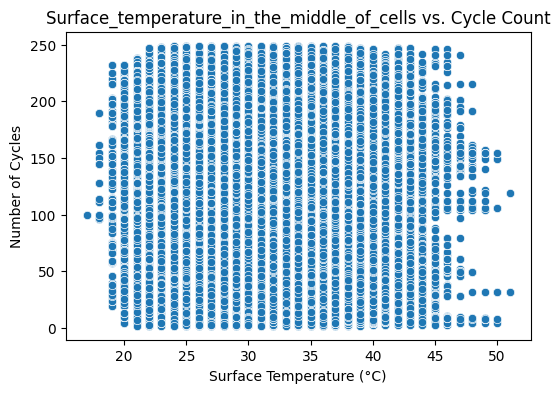

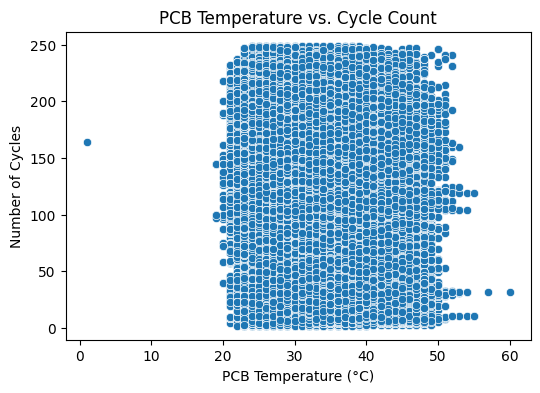

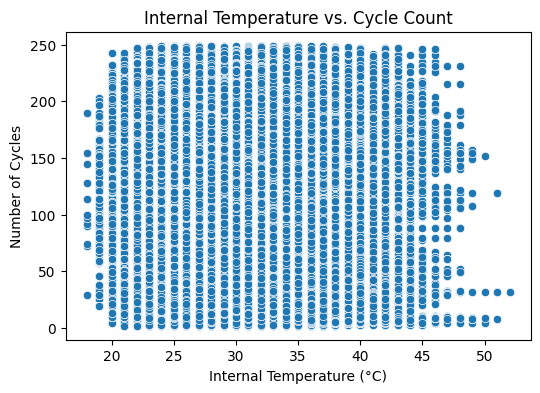

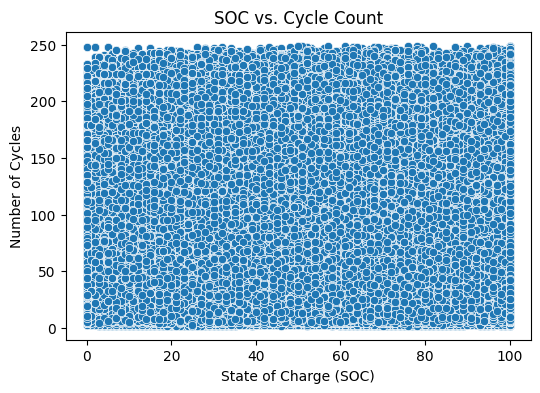

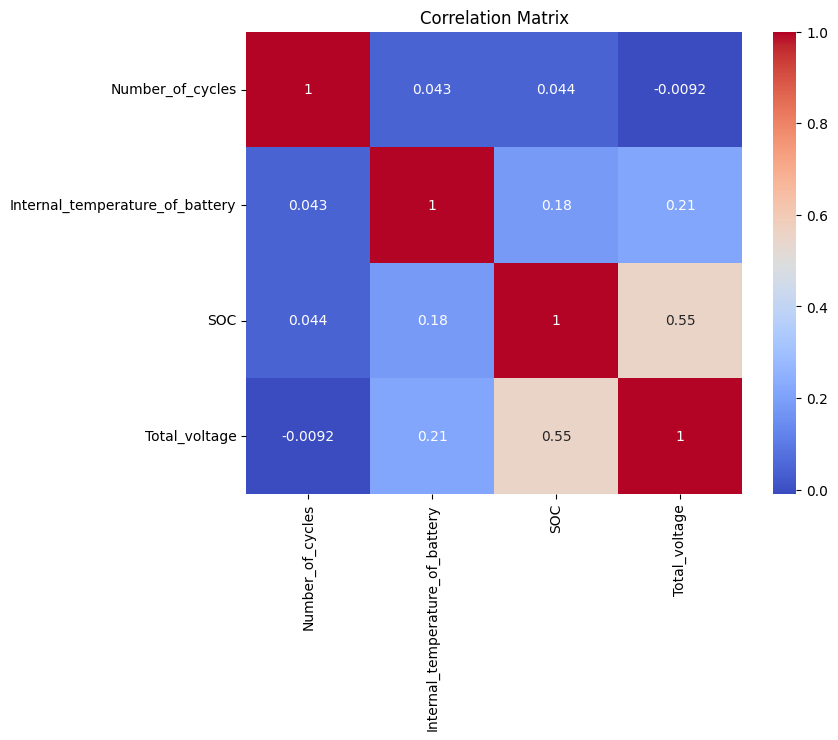

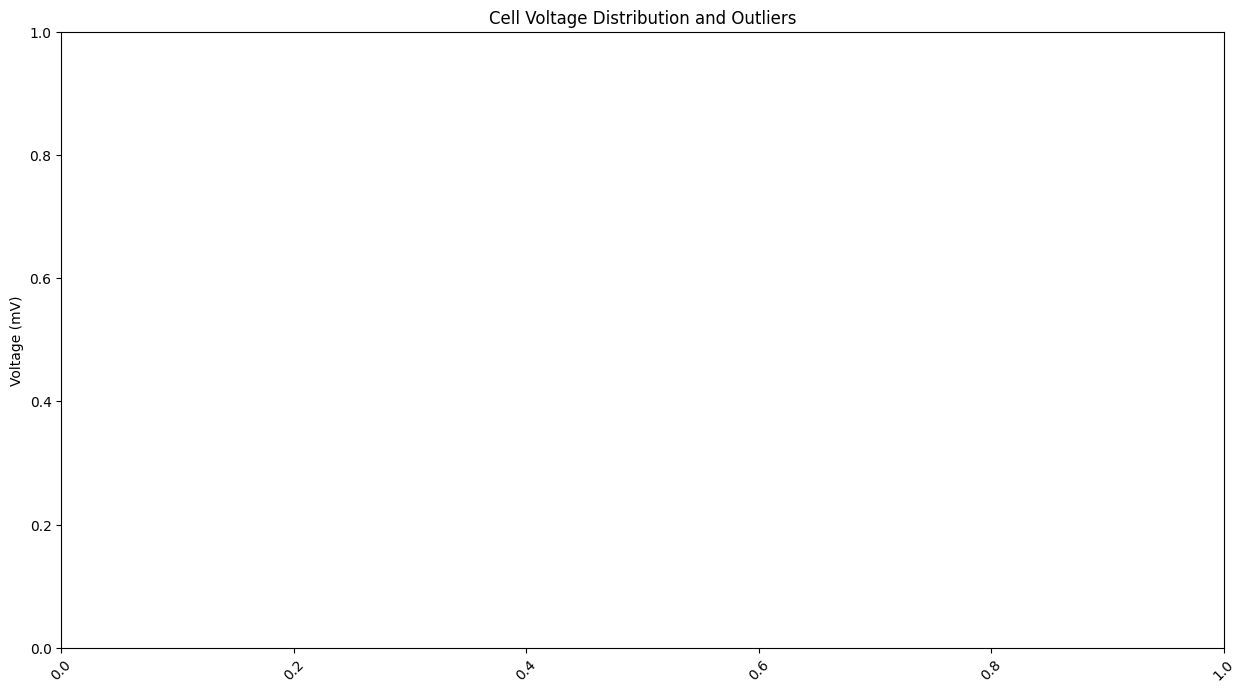

In [ ]:
df = load_data_from_bigquery_sql(project_id, dataset_id, table_id)
df = preprocess_data(df)
analyze_cycle_life(df)

In [9]:
def analyze_battery_maintenance(project_id):
    """Analyzes data for battery maintenance"""

    query_alarm = """
                  select t.alarmDesc
                  from `zembo-demo.zembo_data.battery-data` as t
                  where t.devID like 'BGU%'
                  and t.timestamp is not null
                  and t.alarmDesc <= 12 and t.alarmDesc >= 0;
                  """

    df = load_data_from_bigquery_sql_query(query_alarm, project_id)

    if 'alarmDesc' in df.columns:
      alarm_counts = df['alarmDesc'].value_counts()
      plt.figure(figsize=(10, 6))
      sns.barplot(x=alarm_counts.index, y=alarm_counts.values)
      plt.title('Alarm Frequency')
      plt.xticks(rotation=45)
      plt.xlabel('Alarm Description')
      plt.ylabel('Frequency')
      plt.show()

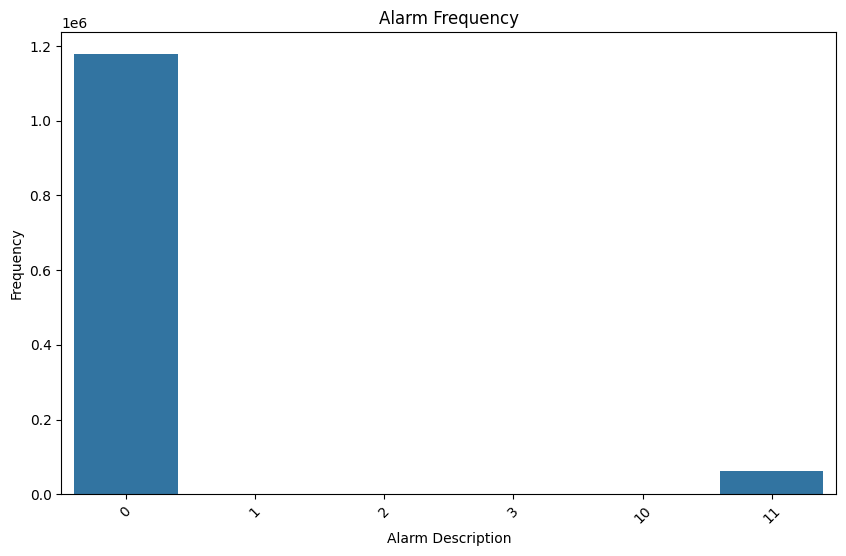

In [12]:
analyze_battery_maintenance(project_id='zembo-demo')